### Étude de la molécule DMAC-TRZ avec la base 6-31G et la fonctionnelle B3LYP 
Afin de pouvoir comparer les résultats avec ceux de références 


In [1]:
import os
import time
import datetime
import subprocess as sp
from pathlib import Path
import pandas as pd
import numpy as np

from rdkit import Chem
from rdkit.Chem import AllChem, Descriptors, Draw
from rdkit.Contrib.SA_Score import sascorer
from rdkit.Contrib.NP_Score import npscorer

from pyscf.data import nist
from pyscf import gto, scf, dft, tddft, sgx
from pyscf.lib import chkfile
from pyscf.tools import cubegen, molden

au2ev = nist.HARTREE2EV

In [2]:
!crest --version

 
       ╔════════════════════════════════════════════╗
       ║            ___ ___ ___ ___ _____           ║
       ║           / __| _ \ __/ __|_   _|          ║
       ║          | (__|   / _|\__ \ | |            ║
       ║           \___|_|_\___|___/ |_|            ║
       ║                                            ║
       ║  Conformer-Rotamer Ensemble Sampling Tool  ║
       ║          based on the xTB methods          ║
       ║                                            ║
       ╚════════════════════════════════════════════╝
       Version 3.0.1, Mon May  6 18:43:33 UTC 2024
       commit (1782d7d) compiled by 'runner@fv-az772-53'
 
 crest 3.0.1


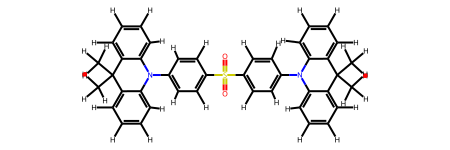

In [14]:
smi = 'CC1(C2=CC=CC=C2N(C3=CC=CC=C31)C4=CC=C(C=C4)S(=O)(=O)C5=CC=C(C=C5)N6C7=CC=CC=C7C(C8=CC=CC=C86)(C)C)C'
smi_key = 'DMAC-TRZ'
m = Chem.MolFromSmiles(smi)
mol = AllChem.AddHs(m)
mol

In [15]:
data = []

Molwt = Descriptors.ExactMolWt(mol)
Solubility = Descriptors.MolLogP(mol)
hbd = Descriptors.NumHDonors(mol)
hba = Descriptors.NumHAcceptors(mol)
tpsa = Descriptors.TPSA(mol)
mol_rdkit = m 
Sa_score = sascorer.calculateScore(mol_rdkit)
# Sa_score = (-(0.92 + (1.082 * Solubility) - (0.5 * Molwt ** 0.5))) / 2.24
num_atoms = mol.GetNumAtoms()

molecular_properties = {
    'Molecule': smi_key,
    'Molecular Weight': Molwt,
    'LogP': Solubility,
    'Hbd': hbd,
    'Hba': hba,
    'TPSA': tpsa,
    'SA-SCORE': Sa_score,
    'Number of atoms':num_atoms
}
data.append(molecular_properties)

df = pd.DataFrame(data)
df.set_index('Molecule', inplace=True)
df

[16:09:27] DEPRECATION WARNING: please use MorganGenerator


,Molecular Weight,LogP,Hbd,Hba,TPSA,SA-SCORE,Number of atoms
Molecule,,,,,,,
DMAC-TRZ,632.249749,10.7376,0,4,40.62,2.435158,83


In [16]:
# Verify if the "data2402_{smi_key}" subdirectory exist and if not, create it
working_dir = Path(f'./Bons2406/{smi_key}')
# Create the output directory if it doesn't exist
working_dir.mkdir(parents=True, exist_ok=True)

In [17]:
path_xtb_xyz = os.path.join(working_dir, f'{smi_key}_xtb.xyz')
path_xtb_opt_log = os.path.join(working_dir, f'{smi_key}_xtb_opt.log')
path_xtb_Pre_opt_log = os.path.join(working_dir, f'{smi_key}_xtb_Pre_opt.log')
path_xtb_opt = os.path.join(working_dir, f'{smi_key}_xtb-crest_optimization')
path_xyz = os.path.join(working_dir, f'{smi_key}.xyz')

In [18]:
def generate_3d_rdkit_conformation(smi_key, smi, working_dir):
    """Generate RDKit 3D optimized conformation of a molecule from smiS
        and store the xyz coordinates in a file

    Args:
        smi (str): The smiS string of the molecule
        working_dir (Path): The directory path where results of calculations will be saved

    Returns:
        mol_xyz (str): xyz coordinates of the RDKit molecule object
        with optimized 3D conformation

    """
    smi_key = smi.replace('/', '_')
    path_xyz = working_dir / f'{smi_key}.xyz'

    if not smi:
        raise ValueError("Invalid smiS string")

    if not path_xyz.exists():
        # Defines a molecule from its smiS string
        mol_rdkit = Chem.MolFromSmiles(smi)

        # Add explicit Hs
        mol_rdkit = Chem.AddHs(mol_rdkit)

        # Generates the initial 3D conformation of the molecule
        AllChem.EmbedMolecule(mol_rdkit)

        # Optimizes the 3D conformation of the molecule using MMFF - Merck Molecular Force Field
        AllChem.MMFFOptimizeMolecule(mol_rdkit, maxIters=200, mmffVariant="MMFF94s")

        # Canonicalize the orientation of the conformation
        Chem.rdMolTransforms.CanonicalizeMol(mol_rdkit, normalizeCovar=True, ignoreHs=False)

        # Convert RDKit molecule to XYZ format
        mol_xyz = Chem.MolToXYZBlock(mol_rdkit)

        # try:
        #     path_xyz.parent.mkdir(parents=True, exist_ok=True)
        #     with path_xyz.open("w") as f:
        #         f.write(mol_xyz)
        # except Exception as e:
        #     print(f"Error occurred while writing the XYZ file: {e}")
        #     return None
    else:
        with path_xyz.open("r") as f:
            mol_xyz = f.read()

    # Remove the first line (number of atoms) from XYZ data
    # mol_xyz = '\n'.join(mol_xyz.strip().split('\n')[1:])

    return mol_xyz,mol

In [19]:
mol_xyz,mol=generate_3d_rdkit_conformation(smi_key, smi, working_dir)

In [20]:
with open("mole_Conf.xyz", "w") as f:
    f.write(mol_xyz)

!cp mole_Conf.xyz {path_xyz}

In [21]:
with open(path_xyz, "w") as f:
        f.write(mol_xyz)

In [22]:
xtb_processP = sp.run(['xtb', path_xyz, '--gfn', '2', '--ohess', '--opt', 'vtight', '--parallel', 'nproc --ignore=2'],
                         stdout=sp.PIPE, stderr=sp.PIPE, text=True, universal_newlines=True)

KeyboardInterrupt: 

In [12]:
# Best conformation search with CREST
sp.run(['crest', 'xtbopt.xyz', '--gfn2', '--mquick', '--prop', 'hess', '--noreftopo', '-T', 'nproc --ignore=2'],stdout=sp.DEVNULL, stderr=sp.DEVNULL)

CompletedProcess(args=['crest', 'xtbopt.xyz', '--gfn2', '--mquick', '--prop', 'hess', '--noreftopo', '-T', 'nproc --ignore=2'], returncode=195)

In [19]:
# optimization with xtb
xtb_process = sp.run(['xtb', 'crest_best.xyz', '--gfn 2', '--opt vtight', '--parallel', 'nproc --ignore=2', 'xtbopt2.out'])


      -----------------------------------------------------------      
     |                   =====================                   |     
     |                           x T B                           |     
     |                   =====================                   |     
     |                         S. Grimme                         |     
     |          Mulliken Center for Theoretical Chemistry        |     
     |                    University of Bonn                     |     
      -----------------------------------------------------------      

   * xtb version 6.6.1 (8d0f1dd) compiled by 'conda@1efc2f54142f' on 2023-08-01

   xtb is free software: you can redistribute it and/or modify it under
   the terms of the GNU Lesser General Public License as published by
   the Free Software Foundation, either version 3 of the License, or
   (at your option) any later version.
   
   xtb is distributed in the hope that it will be useful,
   but WITHOUT ANY WARRANTY; w

normal termination of xtb
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG IEEE_DENORMAL


In [21]:
!cp xtbopt.xyz {path_xtb_xyz}
!cp xtbopt2.out {path_xtb_opt_log}

cp: cannot stat 'xtbopt2.out': No such file or directory


In [8]:
def xyz_opt_xtb(smi_key, smi, working_dir):
    # Set paths for XTB optimization files
    path_xyz = working_dir / f"{smi_key}.xyz"
    path_xtb_log = working_dir / f"{smi_key}_xtb_opt.log"
    path_crest_log = working_dir / f"{smi_key}_crest_opt.log"
    path_xtb_xyz = working_dir / f"{smi_key}_xtb.xyz"

    # Generate 3D coordinates
    mol_xyz, mol = generate_3d_rdkit_conformation(smi_key, smi, working_dir)

    with open(path_xyz, "w") as f:
        f.write(mol_xyz)

    # pre-optimization with xtb
    xtb_processP = sp.run(['xtb', path_xyz, '--gfn', '2', '--ohess', '--opt', 'vtight', '--parallel', 'nproc --ignore=2'],
                         stdout=sp.PIPE, stderr=sp.PIPE, text=True, universal_newlines=True)

    # Best conformation search with CREST
    sp.run(['crest', 'xtbopt.xyz', '--gfn2', '--mquick', '--prop', 'hess', '--noreftopo', '-T', 'nproc --ignore=2'],
           stdout=sp.DEVNULL, stderr=sp.DEVNULL)
    
    # optimization with xtb
    xtb_process = sp.run(['xtb', 'crest_best.xyz', '--gfn 2', '--opt vtight', '--parallel', 'nproc --ignore=2', 'xtbopt2.out'],
                        stdout=sp.PIPE, stderr=sp.PIPE, text=True, universal_newlines=True)

    !cp xtbopt.xyz {path_xtb_xyz}

    return xtb_process
    

In [9]:
xtb_process = xyz_opt_xtb(smi_key, smi, working_dir)

In [11]:
# Read the XYZ file
with open(path_xtb_xyz, 'r') as f:
    mol_xtb_xyz = f.read()
lines = mol_xtb_xyz.strip().split('\n')
mol_xtb_xyz = '\n'.join(lines[:1] + [''] + lines[2:])

In [12]:
with open("mol_xtb.xyz", "w") as f:
    f.write(mol_xtb_xyz)

In [13]:
blocklines2='\n'.join(mol_xtb_xyz.strip().split('\n')[1:])
print(blocklines2)


C            6.89516010757241       -1.24218548653609        0.21669861394489
C            6.01368808614814        0.00218912687110        0.00453032161932
C            5.16370661777999        0.20910776960393        1.24368804480325
C            5.78235099966103        0.40876229972193        2.47025582549553
C            5.06161162952377        0.57968298880230        3.63749408949853
C            3.67999344549196        0.53828339162269        3.59045910993269
C            3.03937630702585        0.34226871654885        2.38534730499150
C            3.76583235168502        0.19113100682120        1.20043372065398
N            3.09345114084413        0.00077089297045        0.00284026580249
C            3.76737891284619       -0.19036583124173       -1.19376572084253
C            3.04247240950157       -0.34384893919855       -2.37932596896751
C            3.68470363592628       -0.54057605935281       -3.58346317178637
C            5.06642830692363       -0.58002222095731       -3.

In [14]:
# import subprocess as sp
# from pathlib import Path
# from rdkit import Chem
# from rdkit.Chem import AllChem
# from rdkit.Chem import rdmolfiles


# def generate_3d_rdkit_conformation(smi_key, smi, working_dir):
#     """
#     Generate 3D conformation for a molecule from its SMILES string using RDKit.

#     Args:
#         smi_key (str): A unique key for the molecule.
#         smi (str): The SMILES string of the molecule.
#         working_dir (str or Path): The working directory where the XYZ file will be saved.

#     Returns:
#         tuple: A tuple containing the XYZ coordinates as a string and the RDKit molecule object.
#     """
#     mol = Chem.MolFromSmiles(smi)
#     if mol is None:
#         raise ValueError(f"Invalid SMILES string: {smi}")

#     mol = Chem.AddHs(mol)  # Ajouter des hydrogènes explicites
#     AllChem.EmbedMolecule(mol, AllChem.ETKDG())
#     AllChem.UFFOptimizeMolecule(mol)

#     xyz = rdmolfiles.MolToXYZBlock(mol)
#     return xyz, mol


# def xyz_opt_xtb(smi_key, smi, working_dir, phase='gas', nproc=4):
#     """
#     Perform XTB optimization on the generated XYZ coordinates.

#     Args:
#         smi_key (str): A unique key for the molecule.
#         smi (str): The SMILES string of the molecule.
#         working_dir (str or Path): The working directory where the optimization files will be saved.
#         phase (str): The phase to perform the optimization in (e.g., 'gas', 'water').
#         nproc (int): Number of processors to use for parallel processing.

#     Returns:
#         str: The optimized XYZ coordinates, or None if the optimization failed.
#     """
#     working_dir = Path(working_dir)
#     working_dir.mkdir(parents=True, exist_ok=True)

#     # Set paths for XTB optimization files
#     path_xyz = working_dir / f"{smi_key}.xyz"
#     path_xtb_log = working_dir / f"{smi_key}_xtb_opt.log"
#     path_crest_log = working_dir / f"{smi_key}_crest_opt.log"

#     # Generate 3D coordinates
#     mol_xyz, mol = generate_3d_rdkit_conformation(smi_key, smi, working_dir)

#     with open(path_xyz, "w") as f:
#         f.write(mol_xyz)

#     # Define xTB and CREST commands
#     xtb_cmd = [
#         'xtb', str(path_xyz), '--gfn', '2', '--opt', 'vtight', '--parallel', str(nproc)
#     ]
#     crest_cmd = [
#         'crest', 'xtbopt.xyz', '--gfn2', '--mquick', '--noreftopo', '-T', str(nproc)
#     ]

#     if phase != 'gas':
#         xtb_cmd.extend(['--alpb', phase])
#         crest_cmd.extend(['--alpb', phase])

#     # Pre-optimization with xTB
#     xtb_process = sp.run(xtb_cmd, cwd=working_dir, stdout=sp.PIPE, stderr=sp.PIPE, text=True)
#     with open(path_xtb_log, "w") as fl:
#         fl.write(xtb_process.stdout)
#         fl.write(xtb_process.stderr)

#     if xtb_process.returncode != 0:
#         print(f"Error during xTB pre-optimization for {smi_key}")
#         print(xtb_process.stderr)
#         return None

#     # Check if xtbopt.xyz was generated
#     xtbopt_path = working_dir / "xtbopt.xyz"
#     if not xtbopt_path.exists():
#         print(f"Error: xTB optimized file not found for {smi_key}")
#         return None

#     # Best conformation search with CREST
#     crest_process = sp.run(crest_cmd, cwd=working_dir, stdout=sp.PIPE, stderr=sp.PIPE, text=True)
#     with open(path_crest_log, "w") as fl:
#         fl.write(crest_process.stdout)
#         fl.write(crest_process.stderr)

#     if crest_process.returncode != 0:
#         print(f"Error during CREST conformation search for {smi_key}")
#         print(crest_process.stderr)
#         return None

#     # Check if crest_best.xyz was generated
#     crest_best_path = working_dir / "crest_best.xyz"
#     if not crest_best_path.exists():
#         print(f"Error: CREST best conformation file not found for {smi_key}")
#         return None

#     # Final optimization with xTB
#     xtb_cmd[1] = "crest_best.xyz"
#     xtb_process = sp.run(xtb_cmd, cwd=working_dir, stdout=sp.PIPE, stderr=sp.PIPE, text=True)

#     # Save the final optimization log
#     with open(path_xtb_log, "a") as fl:
#         fl.write(xtb_process.stdout)
#         fl.write(xtb_process.stderr)

#     if xtb_process.returncode != 0:
#         print(f"Error during final xTB optimization for {smi_key}")
#         print(xtb_process.stderr)
#         return None

#     # Check if the optimized XYZ file exists
#     optimized_xyz_file = working_dir / "xtbopt.xyz"
#     if optimized_xyz_file.exists():
#         with open(optimized_xyz_file, "r") as f:
#             optimized_xyz = f.read()
#         return optimized_xyz
#     else:
#         print(f"Error: Optimized XYZ file not found for {smi_key}")
#         return None


# # Exemple d'utilisation
# smi_key = "molecule1"
# smi = "CC1(C2=CC=CC=C2N(C3=CC=CC=C31)C4=CC=C(C=C4)C5=NC(=NC(=N5)C6=CC=CC=C6)C7=CC=CC=C7)C"  # Exemple de chaîne SMILES
# working_dir = "working_directory"

# optimized_xyz = xyz_opt_xtb(smi_key, smi, working_dir, phase='water', nproc=4)
# if optimized_xyz:
#     print(f"Structure optimisée pour {smi_key}:\n{optimized_xyz}")
# else:
#     print(f"Optimization failed for {smi_key}. Check log files for details.")

In [15]:
def pyscf_molecule_object(smi_key, smi, working_dir, basis='631g'):
    """
    Crée un objet molécule PySCF à partir d'un smiS.
    
    Args:
        smi_key (str): Clé smiS
        smi (str): Chaîne smiS
        working_dir (str): Répertoire de travail
        basis (str, optional): Ensemble de base à utiliser, par défaut '631g*'
    
    Returns:
        pyscf.gto.Mole: Objet molécule PySCF
    """

    mol_pyscf = gto.Mole()
    mol_pyscf.build(
        atom=blocklines2,
        basis=basis,
        symmetry=True,
        unit='Angstrom'
    )
    
    return mol_pyscf

In [16]:
pyscf_molecule_object(smi_key, smi, working_dir, basis='631g')

In [17]:
def tddft_osc_strength_calculations(smi_key, smi, working_dir):
    """PySCF TDDFT-TDA calculations of fluorescence energy,
    singlet-triplet gap and oscillator strength

    Part of code is from https://github.com/aspuru-guzik-group/Tartarus

    Args:
        smi_key (str): smi key
        smi (str): The smiS string of the molecule
        working_dir (str): The directory path where results of calculations will be saved
        phase (str) : 'gas' for the gas-phase or 'sol' for solvation

    """

     # PySCF molecule object
    mol_pyscf = pyscf_molecule_object(smi_key, smi, working_dir, basis = '631g*')

    #=====================================
    # DFT CALCULATIONS
    #=====================================

   # Setting path for DFT results, chkfile and analyze object
    path_results = os.path.join(working_dir, f'Results_{smi_key}.csv')
    path_DFT_chk = os.path.join(working_dir, f'{smi_key}_DFT.chk')
    path_DFT_txt = os.path.join(working_dir, f'{smi_key}_DFT.txt')

    mol_pyscf.output = path_DFT_txt

    # Singlets GS DFT calculations
    mdft = dft.RKS(mol_pyscf)
    mdft.xc = 'B3LYP'
    mdft.max_cycle = 512
    mdft.grids.level = 0
    mdft.conv_tol = 1E-7
    # if phase == 'sol':
    #     mdft = mdft.ddCOSMO()
    #     mdft.with_solvent.eps = 2.3741   # Toluene
    # mdft.density_fit(auxbasis='def2-universal-jkfit')

    if os.path.exists(path_DFT_chk):
        path_DFT_status = f'{path_DFT_chk} exist'
        start = time.time()

        # Load the DFT results from the checkpoint file
        mdft.__dict__.update(chkfile.load(path_DFT_chk, 'scf'))
        mdft.kernel()

        elapsed_DFT = str(datetime.timedelta(
            seconds = time.time() - start))
    else:
        path_DFT_status = f'{path_DFT_chk} don\'t exist'
        start = time.time()

        # Save the DFT results to a checkpoint file
        mdft.chkfile = path_DFT_chk
        mdft.kernel()
        if(not mdft.converged):
            mdft = mdft.newton(mdft)
            mdft.kernel()

        elapsed_DFT = str(datetime.timedelta(
            seconds = time.time()- start))

    # Analyze the given DFT object
    mdft.analyze()

    # Index of HOMO and LUMO
    homo_idx = np.where(mdft.mo_occ > 0)[0][-1]
    lumo_idx = np.where(mdft.mo_occ == 0)[0][0]

    # Create the DFT results dataframe
    list_results_DFT = [mdft.e_tot,
                        mdft.energy_elec()[0],
                        mdft.energy_nuc(),
                        mdft.mo_energy[homo_idx],
                        mdft.mo_energy[lumo_idx]]
    dict_results_DFT = {'Hartree': list_results_DFT,
                    'eV': [x * au2ev for x in list_results_DFT]}
    df_DFT = pd.DataFrame(dict_results_DFT,
                        index = ['Total energy',
                                 'Electronic energy',
                                 'Nuclear repulsion energy',
                                 'MO energy of HOMO',
                                 'MO energy of LUMO'])
    return df_DFT,mdft,path_results,elapsed_DFT,path_DFT_status


In [18]:
df_DFT,mdft,path_results,elapsed_DFT,path_DFT_status=tddft_osc_strength_calculations(smi_key, smi, working_dir)

/home/elvira/miniconda3/lib/python3.12/site-packages/pyscf/dft/libxc.py:1102: UserWarning: Since PySCF-2.3, B3LYP (and B3P86) are changed to the VWN-RPA variant, corresponding to the original definition by Stephens et al. (issue 1480) and the same as the B3LYP functional in Gaussian. To restore the VWN5 definition, you can put the setting "B3LYP_WITH_VWN5 = True" in pyscf_conf.py
  warnings.warn('Since PySCF-2.3, B3LYP (and B3P86) are changed to the VWN-RPA variant, '


converged SCF energy = -1607.83535450269
**** MO energy ****
MO #1   energy= -14.366400546989   occ= 2
MO #2   energy= -14.3368115297385  occ= 2
MO #3   energy= -14.336803038995   occ= 2
MO #4   energy= -14.336744070114   occ= 2
MO #5   energy= -10.2724414642893  occ= 2
MO #6   energy= -10.2716103280245  occ= 2
MO #7   energy= -10.271583899512   occ= 2
MO #8   energy= -10.2338490509493  occ= 2
MO #9   energy= -10.2221876727881  occ= 2
MO #10  energy= -10.2221833203388  occ= 2
MO #11  energy= -10.2010513465102  occ= 2
MO #12  energy= -10.1992028166144  occ= 2
MO #13  energy= -10.1955775870008  occ= 2
MO #14  energy= -10.1955599881739  occ= 2
MO #15  energy= -10.1950595600532  occ= 2
MO #16  energy= -10.1950477080224  occ= 2
MO #17  energy= -10.1947450586214  occ= 2
MO #18  energy= -10.1947438743451  occ= 2
MO #19  energy= -10.1928892445577  occ= 2
MO #20  energy= -10.1928878506594  occ= 2
MO #21  energy= -10.1889643718345  occ= 2
MO #22  energy= -10.1889636842962  occ= 2
MO #23  energy=

In [19]:
df_DFT

,Hartree,eV
Total energy,-1607.835355,-43751.428488
Electronic energy,-5581.996184,-151893.852937
Nuclear repulsion energy,3974.160830,108142.424449
MO energy of HOMO,-0.178923,-4.868741
MO energy of LUMO,-0.071060,-1.933634


In [31]:
def tda_osc_strength_calculations(smi_key, smi, mdft, path_results, elapsed_DFT, path_DFT_status, df_DFT, working_dir):
    
    mftda = tddft.TDA(mdft)
    mftda.nstates = 2
    # if phase == 'sol':
    #     mftda = mftda.ddCOSMO()
    #     mftda.with_solvent.eps = 2.3741   # Toluene
    #     mftda.with_solvent.equilibrum_solvation = True

    # Setting path for singlets TDDFT-TDA chkfile
    path_TDA_chk = os.path.join(working_dir, f'{smi_key}_TDA.chk')

    if os.path.exists(path_TDA_chk):
        path_TDA_status = f'{path_TDA_chk} exist'
        start = time.time()

        # Load the TDA singlet results from the checkpoint file
        mftda.__dict__.update(chkfile.load(path_TDA_chk, 'tddft'))
        E_TDA = mftda.kernel()

        elapsed_TDA = str(datetime.timedelta(
            seconds=time.time() - start))
    else:
        path_TDA_status = f'{path_TDA_chk} don\'t exist'
        start = time.time()

        # Save the TDA singlet results to a checkpoint file
        mftda.chkfile = path_TDA_chk
        E_TDA = mftda.kernel()
        #if(not mftda.converged):
        #    mftda = tddft.TDA.newton(mftda)
        #    E_TDA = mftda.kernel()

        elapsed_TDA = str(datetime.timedelta(
            seconds=time.time() - start))

    # Singlet excitation energies
    ee_singlets = mftda.e

    # Singlet oscillators strength
    OS_singlets = mftda.oscillator_strength(gauge='length')

    # Triplets ES TDDFT calculations with Tamm-Dancoff-approximation
    #==================================
    mftda.singlet = False

    # Setting path for triplets TDDFT-TDA chkfile
    path_TDA3_chk = os.path.join(working_dir, f'{smi_key}_TDA3.chk')

    if os.path.exists(path_TDA3_chk):
        path_TDA3_status = f'{path_TDA3_chk} exist'
        start = time.time()

        # Load the TDA triplet results from the checkpoint file
        mftda.__dict__.update(chkfile.load(path_TDA3_chk, 'tddft'))
        E_TDA3 = mftda.kernel()

        elapsed_TDA3 = str(datetime.timedelta(
            seconds=time.time() - start))
    else:
        path_TDA3_status = f'{path_TDA3_chk} don\'t exist'
        start = time.time()

        # Save the TDA results to a checkpoint file
        mftda.chkfile = path_TDA3_chk
        E_TDA3 = mftda.kernel()

        elapsed_TDA3 = str(datetime.timedelta(
            seconds=time.time() - start))

    # Triplet excitation energies
    ee_triplets = mftda.e

    # Sought results
    #==================================
    #
    # fluorescence energy
    f_energy = min(ee_singlets)

    # Singlet-Tiplet gap
    gap_ST = min(ee_singlets) - min(ee_triplets)

    # Oscillator strength
    OStr = OS_singlets[0]

    # Lifetime calculation in au
    c = nist.LIGHT_SPEED # in au
    time_au = 2.4188843265857E-17 # in au

    tau_au = c**3 / (2 * (f_energy)**2 * OStr)
    tau = tau_au * time_au

    # Multi-Objective function
    mobj = OStr - gap_ST * au2ev - np.abs(f_energy * au2ev - 3.2)

    #=====================================
    # DataFrame and saving in file
    #=====================================

    # Create the results dataframe
    list_results_TDA = [f_energy, gap_ST, OStr, tau, mobj]
    dict_results_TDA = {'a.u.': list_results_TDA,
                        'eV/ns': [f_energy * au2ev,
                                gap_ST * au2ev,
                                OStr,
                                tau * 1E+9,
                                mobj]}

    df_TDA = pd.DataFrame(dict_results_TDA,
                        index=['Fluorescence energy',
                                'Singlet-Triplet gap',
                                'Oscillator strength',
                                'Lifetime',
                                'Multi-Obj'])

    # Save the DFT and TDDFT-TDA results dataframe to a file

    with open(path_results, "a") as f:
        f.write(f"\n\nDFT calculations of {smi_key} obtained in; \
            {elapsed_DFT}s ; as {path_DFT_status} \n")
        df_DFT.to_csv('patrick1.csv')

        f.write(f"\n\nTDDFT-TDA calculations of {smi_key} obtained in; \
                {elapsed_TDA}s ; as {path_TDA_status}\n \
                {elapsed_TDA3}s ; as {path_TDA3_status}\n")
        df_TDA.to_csv('elvis.csv')
        return df_TDA

In [32]:
df_TDA=tda_osc_strength_calculations(smi_key, smi, mdft, path_results, elapsed_DFT, path_DFT_status, df_DFT, working_dir)

Excited State energies (eV)
[2.43256269 2.67840317]
Excited State energies (eV)
[2.38276877 2.67255112]


In [33]:
df_TDA

,a.u.,eV/ns
Fluorescence energy,8.939503e-02,2.432563
Singlet-Triplet gap,1.829893e-03,0.049794
Oscillator strength,4.235924e-02,0.042359
Lifetime,9.194205e-08,91.942050
Multi-Obj,-7.748720e-01,-0.774872
